## Srijan Bhushan
## TSA Assignment 2
#### Code attached below

In [418]:

# ------------------------- #
# By Srijan Bhushan         #
# Roll No: MDS202039        #
# email: srijanb@cmi.ac.in  #
# Time Series Analysis      #
# Assignment 2              #
# ------------------------- #

# All python code will be in boxes like these
# and the relevant output below
print("This is python code output.")


This is python code output.


# Initial Programming

In [78]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arch.unitroot as stat_tests
import datetime
from statsmodels.tsa.arima.model import ARIMA
import warnings
from arch import arch_model
import statsmodels.api as sm # for applying the Ljung - Box test

warnings.filterwarnings('ignore')

## Loading the data

The data is the Adjusted Close price of NASDAQ composite stock data in USD.
We have taken data from 28 Novemeber 2014 to 28 November 2018 so as to avoid
any effects covid may have had on the stock.

The dataset was taken from:  
https://finance.yahoo.com/quote/%5EIXIC/history?period1=
1417132800&period2=1543363200&interval=1d&filter=history&
frequency=1d&includeAdjustedClose=true

In [79]:

"""
Dataset link:
https://finance.yahoo.com/quote/%5EIXIC/history?period1=
1417132800&period2=1543363200&interval=1d&filter=history&
frequency=1d&includeAdjustedClose=true

NASDAQ Composite data
28 Nov 2014 to 28 Nov 2018

taken so old to ensure lack of covid effects
"""

## IMPORTING THE DATA
data = pd.read_csv('IXIC.csv')[['Date', 'Adj Close']]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')
;


''

## Basic Data Preprocessing

In [195]:
# We have a look at the first few rows of the data
data.head(10)


,Adj Close
Date,
2014-11-28,4791.629883
2014-12-01,4727.350098
2014-12-02,4755.810059
2014-12-03,4774.470215
2014-12-04,4769.439941
2014-12-05,4780.759766
2014-12-08,4740.689941
2014-12-09,4766.470215
2014-12-10,4684.020020


### Data Plot

<AxesSubplot:title={'center':'Plot of NASDAQ Composite Adj Close data from 2014 to 2018'}, xlabel='Date'>

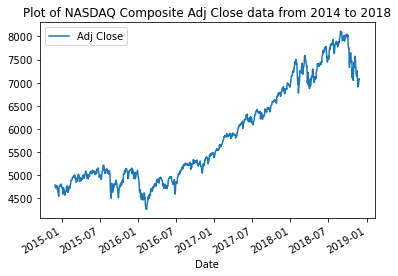

In [81]:
# let us plot our data
data.plot(title='Plot of NASDAQ Composite Adj Close data from 2014 to 2018')


### Ensuring no missing values

In [82]:
print(f"Our data contains {data.shape[0]} rows")
print(f"Our data contains {data.isna().sum()[-1]} missing values")


Our data contains 1007 rows
Our data contains 0 missing values


### Printing the range of data from 3 standard deviations

In [83]:
print(f"Range is:({data.mean()[-1] - 3*data.std()[-1]}, {data.mean()[-1] + 3*data.std()[-1]})")


Range is:(2629.3083363129717, 9068.25482699984)


### Capping data on above mentioned range

In [84]:
lim_sup = data.mean()[-1] + 3*data.std()[-1]
lim_inf = data.mean()[-1] - 3*data.std()[-1]

# capping on lim_sup
temp_copy = data["Adj Close"].copy()
data["Adj Close"] = np.where(temp_copy > lim_sup, lim_sup, temp_copy)

# capping on lim_inf
temp_copy = data["Adj Close"].copy()
data["Adj Close"] = np.where(temp_copy < lim_inf, lim_inf, temp_copy)


### Plotting the capped data

<AxesSubplot:title={'center':'Plot of NASDAQ Composite Adj Close data from 2014 to 2018\nAfter Outlier Capping'}, xlabel='Date'>

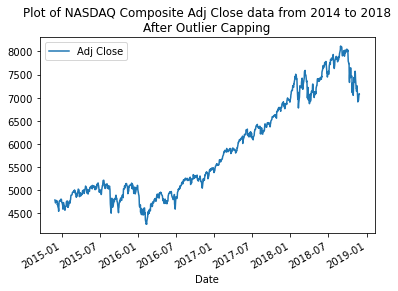

In [85]:
# let us plot our data
data.plot(title='Plot of NASDAQ Composite Adj Close data from 2014 to 2018\nAfter Outlier Capping')


### Descriptive Statistics of the data

In [86]:
data.describe()


,Adj Close
count,1007.000000
mean,5848.781582
std,1073.157748
min,4266.839844
25%,4952.239990
50%,5339.520020
75%,6803.064942
max,8109.689941


### How much data is in the IQR

In [87]:
# We find the IQR range here

# iqr upper bound
iqr_sup = data.mean()[-1] + (1.5)*data.std()[-1]

# iqr lower bound
iqr_inf = data.mean()[-1] - (1.5)*data.std()[-1]

# no. of values in irq range
count = data['Adj Close'].between(iqr_inf, iqr_sup).sum()

print(f"There is approx {round(count/data.shape[0]*100,2)}% of data in IQR range")


There is approx 89.37% of data in IQR range


### Split data

In [88]:
# we look at a description of the data
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-11-28 to 2018-11-27
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1007 non-null   float64
dtypes: float64(1)
memory usage: 15.7 KB


In [89]:
# This data will be used for testing our forecasting
test_data = data[-7:]

# This data will be used for building our ARIMA model
model_data = data[:-7]


## Using Stationary Data

### Calculating returns of the data

In [94]:
### returns of our financial data
def returns(data):
    # transforming values and then taking first difference
    return np.log(data).diff()[1:]


In [95]:
r_model_data = returns(model_data)


### Plotting returns data

<AxesSubplot:title={'center':'Plot of NASDAQ Composite Adj Close data from 2014 to 2018\n On Model Returns Data After Outlier Capping'}, xlabel='Date'>

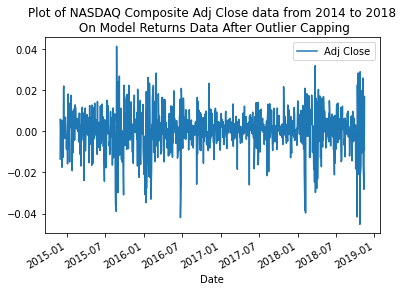

In [96]:
# let us plot our data
r_model_data.plot(title='Plot of NASDAQ Composite Adj Close data from 2014 to 2018\n \
On Model Returns Data After Outlier Capping')


### Stationarity Check

In [97]:
def station_check(entries, pvalue=0.05):
    pp = stat_tests.PhillipsPerron(entries)
    adf = stat_tests.ADF(entries)
    kpss = stat_tests.KPSS(entries)
    # (calculated_pvalue < provided_pvalue) --> reject null
    pp_res, adf_res, kpss_res = pp.pvalue < pvalue, adf.pvalue < pvalue, kpss.pvalue < pvalue
    print(f"""Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: {pp_res == True}
    - adf  verdict: {adf_res == True}
    - kpss verdict: {kpss_res == False} 
    """)
# kpss has a different null that's why '== False' for kpss


In [419]:
## Checking stationarity on un-transformed data
station_check(model_data)


Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: False
    - adf  verdict: False
    - kpss verdict: False 
    


In [98]:
## Checking stationarity on returns data
station_check(r_model_data)


Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: True
    - adf  verdict: True
    - kpss verdict: True 
    


## Fitting Model
Instead of fitting ARMA(p,q) on returns data,  
we fit ARIMA(p,1,q) on log of the data,  
both of the models are essentially the same

In [217]:
## We take the log of the untransformed data and store in the variable log_model_data
log_model_data = np.log(model_data)

In [218]:
%%time

p_lim = 15
q_lim = 15
p_range = [i for i in range(p_lim+1)]
q_range = [i for i in range(q_lim+1)]
aic_matrix = [[None for _ in range(p_lim+1)] for __ in range(q_lim+1)]
bic_matrix = [[None for _ in range(p_lim+1)] for __ in range(q_lim+1)]
print("1. Setup: Basic Variables Set")

for p in p_range:
    for q in q_range:
        if p == 0 and q == 0:
            # arma(0,0) set to a high number (basically no prediction)
            aic_matrix[q][p] = 9999
            bic_matrix[q][p] = 9999
        else:
            # initializing arma(p,q) model
            
            ######################################################
            ## IMPORTANT: (p,1,q) does the first difference
            ##             in-built
            model = ARIMA(log_model_data, order=(p,1,q)) 
            ######################################################
            
            # fitting model to data
            results = model.fit()
            
            # recording the calculated aic and bic scores
            aic_matrix[q][p] = round(results.aic,3) # Imp: we set it as (q,p) not the usual (p,q)
            bic_matrix[q][p] = round(results.bic,3) # Imp: we set it as (q,p) not the usual (p,q)
print("\n2. Processing: Scores Calculation Done")  

# converting to numpy array for better computations
aic_matrix = np.array(aic_matrix)
bic_matrix = np.array(bic_matrix)

# Printing the best results
print("\n\n3. Outputs:")
print(f"Best index as per aic:{np.argwhere(aic_matrix == np.min(aic_matrix))}, score: {np.min(aic_matrix)}")
print(f"\nBest index as per bic:{np.argwhere(bic_matrix == np.min(bic_matrix))}, score: {np.min(bic_matrix)}")
best_tuples = list(np.argwhere(aic_matrix == np.min(aic_matrix)))
temp = list(np.argwhere(bic_matrix == np.min(bic_matrix)))
best_tuples.extend(temp)


1. Setup: Basic Variables Set

2. Processing: Scores Calculation Done


3. Outputs:
Best index as per aic:[[0 8]], score: -6395.178

Best index as per bic:[[0 1]
 [1 0]], score: -6383.383
Wall time: 5min 43s


### Deciding which p,q to pick
From calculating the minimum values, we have 3 optins to pick.  
We will pick the one with the least MSE on train_data

In [ ]:
## OPTIONS WE HAVE:
## (q,p) = (0, 8)
## (q,p) = (0, 1)
## (q,p) = (1 ,0)
## i.e. (p,q) options are (8,0), (1,0), (0,1)

In [226]:
def mse_arma_cal(p,q, model_data=log_model_data.copy(), test_data=test_data.copy()):
    
    ### note: we take first difference, as shown below
    model = ARIMA(log_model_data, order=(p,1,q))
    
    results = model.fit()
    
    # prediction from:
    start_pred = r_model_data.shape[0]
    end_pred = start_pred + test_data.shape[0] -1
    
    forecasts = results.predict(start=start_pred, end=end_pred)
    # remove the log
    predicted_values = np.exp(forecasts)
    
    # calculate mse
    total_predicted_points = test_data.shape[0] 
    predicted_values.index = [x for x in range(total_predicted_points)]
    test_data.index = [x for x in range(total_predicted_points)]
    mse = np.mean( (predicted_values - test_data['Adj Close'])**2 )
    
    return mse


In [420]:
best_tuples

[array([1, 2], dtype=int64), array([1, 1], dtype=int64)]

In [227]:

for q,p in best_tuples:
    print(f"ARMA({p},{q}) gives MSE: {mse_arma_cal(p,q)}")


ARMA(8,0) gives MSE: 66312.37946645282
ARMA(0,1) gives MSE: 62050.57239113515
ARMA(1,0) gives MSE: 61991.30819082364


### Building the chosen model
Arma(1,0) gives the lowest mse, so we pick Arma(1,0) itself.

In [232]:
# ARMA(1,0) on returns = ARIMA(1,1,0) on log-prices
chosen_model = ARIMA(log_model_data, order=(1,1,0)).fit()


In [233]:
chosen_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1000
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3198.598
Date:                Sun, 28 Nov 2021   AIC                          -6393.197
Time:                        18:54:09   BIC                          -6383.383
Sample:                             0   HQIC                         -6389.467
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0037      0.022     -0.171      0.864      -0.046       0.039
sigma2      9.685e-05   2.86e-06     33.878      0.000    9.12e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               368.92
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.60
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for ARMA

In [239]:
predictions = np.exp(chosen_model.predict(start=0,end=model_data.shape[0]-1))
predictions.index = model_data.index

In [240]:
predictions

Date
2014-11-28       1.000000
2014-12-01    4791.629883
2014-12-02    4727.584778
2014-12-03    4755.705139
2014-12-04    4774.401494
                 ...     
2018-11-09    7531.026044
2018-11-12    7407.351843
2018-11-13    7201.616805
2018-11-14    7200.870117
2018-11-15    7136.626078
Name: predicted_mean, Length: 1000, dtype: float64

In [285]:
ARIMA_predictions = np.exp(chosen_model.predict(start=model_data.shape[0], end=model_data.shape[0]+6))
ARIMA_predictions.index = test_data.index

In [286]:
ARIMA_predictions

Date
2018-11-16    7258.575175
2018-11-19    7258.576846
2018-11-20    7258.576840
2018-11-21    7258.576840
2018-11-23    7258.576840
2018-11-26    7258.576840
2018-11-27    7258.576840
Name: predicted_mean, dtype: float64

In [234]:
test_data

,Adj Close
Date,
2018-11-16,7247.870117
2018-11-19,7028.479980
2018-11-20,6908.819824
2018-11-21,6972.250000
2018-11-23,6938.979980
2018-11-26,7081.850098
2018-11-27,7082.700195


In [180]:
model_data


,Adj Close
Date,
2014-11-28,4791.629883
2014-12-01,4727.350098
2014-12-02,4755.810059
2014-12-03,4774.470215
2014-12-04,4769.439941
...,...
2018-11-09,7406.899902
2018-11-12,7200.870117
2018-11-13,7200.870117


''

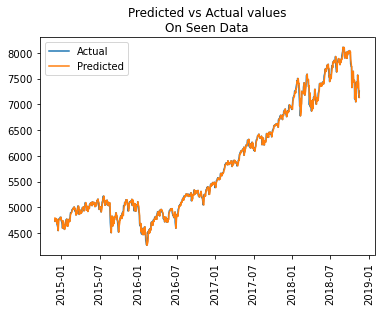

In [287]:
plt.title("Predicted vs Actual values\nOn Seen Data")
plt.plot(model_data[1:],label="Actual")
plt.plot(predictions[1:],label="Predicted")
plt.legend()
plt.xticks(rotation=90)
;

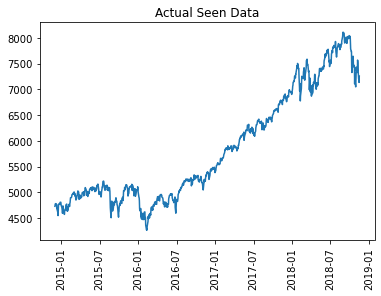

In [289]:
plt.plot(model_data[1:],label="Actual")
plt.title("Actual Seen Data")
plt.xticks(rotation=90);

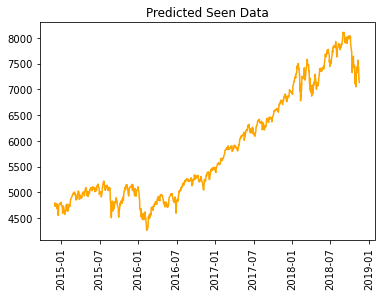

In [291]:
plt.plot(predictions[1:],label="Pred", color='orange')
plt.title("Predicted Seen Data")
plt.xticks(rotation=90);

In [294]:
ARIMA_predictions

Date
2018-11-16    7258.575175
2018-11-19    7258.576846
2018-11-20    7258.576840
2018-11-21    7258.576840
2018-11-23    7258.576840
2018-11-26    7258.576840
2018-11-27    7258.576840
Name: predicted_mean, dtype: float64

''

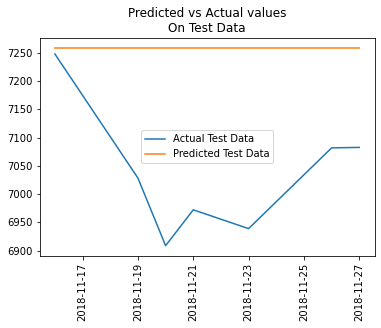

In [295]:
plt.title("Predicted vs Actual values\nOn Test Data")
plt.plot(test_data,label="Actual Test Data")
plt.plot(ARIMA_predictions,label="Predicted Test Data")
plt.legend()
plt.xticks(rotation=90)
;

# Procedure 1
## Calculating Ljung Box test statistic

In [331]:


# Ljung - Box test is the function
# sm.stats.acorr_ljungbox
taken_lag = round(np.log(model_data.shape[0]))
print("For the Ljung-Box test")
print(f"We shall take lag as approx. {taken_lag}")


For the Ljung-Box test
We shall take lag as approx. 7


In [332]:
chosen_model.resid

Date
2014-11-28    8.474626
2014-12-01   -0.013506
2014-12-02    0.005953
2014-12-03    0.003938
2014-12-04   -0.001040
                ...   
2018-11-09   -0.016619
2018-11-12   -0.028271
2018-11-13   -0.000104
2018-11-14   -0.008995
2018-11-15    0.017006
Length: 1000, dtype: float64

In [338]:
# Ljung - Box test on residuals
sm.stats.acorr_ljungbox(chosen_model.resid[1:], lags=[taken_lag])


,lb_stat,lb_pvalue
7,5.121045,0.645194


In [339]:
# jung - Box test on squared residuals
sm.stats.acorr_ljungbox(chosen_model.resid[1:]**2, lags=[taken_lag])


,lb_stat,lb_pvalue
7,260.410446,1.682438e-52


As per Ljung-Box, we reject null on the squared residual errors and  
not-reject null for the usual residual errors

## Finding GARCH

In [353]:
### finding GARCH model
pq_range=10
aic_matrix = [[0 for i in range(pq_range)] for j in range(pq_range)]
bic_matrix = [[0 for i in range(pq_range)] for j in range(pq_range)]
for p in range(pq_range):
    for q in range(pq_range):
        if p==0:
            # GARCH requires positive p
            aic_matrix[p][q] = 9999999999
            bic_matrix[p][q] = 9999999999
        else:
            gar = arch_model(r_model_data, vol="GARCH", p=p, q=q).fit()
            aic_matrix[p][q] = gar.aic
            bic_matrix[p][q] = gar.bic


# converting to numpy array for better computations
aic_matrix = np.array(aic_matrix)
bic_matrix = np.array(bic_matrix)

# Printing the best results
print(f"Best index as per aic:{np.argwhere(aic_matrix == np.min(aic_matrix))}, score: {np.min(aic_matrix)}")
print(f"\nBest index as per bic:{np.argwhere(bic_matrix == np.min(bic_matrix))}, score: {np.min(bic_matrix)}")
best_tuples = list(np.argwhere(aic_matrix == np.min(aic_matrix)))
temp = list(np.argwhere(bic_matrix == np.min(bic_matrix)))
best_tuples.extend(temp)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 783129500792.2668
Iteration:      2,   Func. Count:     17,   Neg. LLF: 6310350016140.84
Iteration:      3,   Func. Count:     31,   Neg. LLF: 55482465612.59042
Iteration:      4,   Func. Count:     45,   Neg. LLF: 20048211493681.027
Iteration:      5,   Func. Count:     59,   Neg. LLF: 58423840.105398424
Iteration:      6,   Func. Count:     70,   Neg. LLF: 117684997.60084875
Iteration:      7,   Func. Count:     81,   Neg. LLF: 26622068.13607467
Iteration:      8,   Func. Count:     92,   Neg. LLF: -3197.7997033528536
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3197.7997005514944
            Iterations: 12
            Function evaluations: 92
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2461464574822445e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2016427826.8538053
Iteration:      3,   Func. Count:     31,   Neg. LLF: 120888

Iteration:      6,   Func. Count:     76,   Neg. LLF: 1186156.7702792818
Iteration:      7,   Func. Count:     91,   Neg. LLF: 4223.3960506989815
Iteration:      8,   Func. Count:    105,   Neg. LLF: 25840.86182822718
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3289.142903608709
            Iterations: 10
            Function evaluations: 112
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     10,   Neg. LLF: 8500637918.356193
Iteration:      2,   Func. Count:     26,   Neg. LLF: -3289.3402856346856
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3289.3402864884483
            Iterations: 6
            Function evaluations: 26
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: 8253409254.820987
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4553604.226491937
Optimization terminated successfully    (Exit mode 0)
            Current

Iteration:      6,   Func. Count:     86,   Neg. LLF: 174788911.94540325
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3249.0502070339717
            Iterations: 8
            Function evaluations: 95
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     10,   Neg. LLF: 55487570725.32197
Iteration:      2,   Func. Count:     26,   Neg. LLF: 13251721844.488403
Iteration:      3,   Func. Count:     42,   Neg. LLF: 1757582960.3675275
Iteration:      4,   Func. Count:     58,   Neg. LLF: 24759470791.60256
Iteration:      5,   Func. Count:     75,   Neg. LLF: -661.9563219046418
Iteration:      6,   Func. Count:     87,   Neg. LLF: 17104519938.706379
Iteration:      7,   Func. Count:    103,   Neg. LLF: 4087849297.117597
Iteration:      8,   Func. Count:    119,   Neg. LLF: 3994542455.312476
Iteration:      9,   Func. Count:    136,   Neg. LLF: 1436430415.9011266
Optimization terminated successfully    (Exit mode 0)
           

Iteration:      1,   Func. Count:     16,   Neg. LLF: 41837631523.67529
Iteration:      2,   Func. Count:     38,   Neg. LLF: 205968.460067651
Iteration:      3,   Func. Count:     58,   Neg. LLF: 132174255.32096136
Iteration:      4,   Func. Count:     81,   Neg. LLF: -3277.8777553041823
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3277.8777566727254
            Iterations: 8
            Function evaluations: 81
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     17,   Neg. LLF: 40266622716.98047
Iteration:      2,   Func. Count:     40,   Neg. LLF: 594617421.608782
Iteration:      3,   Func. Count:     63,   Neg. LLF: 93197179.172616
Iteration:      4,   Func. Count:     86,   Neg. LLF: 89160748.67026852
Iteration:      5,   Func. Count:    108,   Neg. LLF: -3277.674113947236
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3277.674115483266
            Iterations: 9
        

Iteration:      1,   Func. Count:     20,   Neg. LLF: 3779886726.2453237
Iteration:      2,   Func. Count:     46,   Neg. LLF: 6288885.470079885
Iteration:      3,   Func. Count:     71,   Neg. LLF: 259002694.64124447
Iteration:      4,   Func. Count:     97,   Neg. LLF: 17443471.318638902
Iteration:      5,   Func. Count:    123,   Neg. LLF: 99496046.9057103
Iteration:      6,   Func. Count:    149,   Neg. LLF: -3272.533399668894
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3272.5334012217772
            Iterations: 10
            Function evaluations: 149
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     12,   Neg. LLF: 3189804744.2874994
Iteration:      2,   Func. Count:     30,   Neg. LLF: 18968274783.36748
Iteration:      3,   Func. Count:     48,   Neg. LLF: 77070362.4106887
Iteration:      4,   Func. Count:     66,   Neg. LLF: 1337329675.357569
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      4,   Func. Count:     75,   Neg. LLF: 516680.3980240404
Iteration:      5,   Func. Count:     95,   Neg. LLF: 737092.2308066845
Iteration:      6,   Func. Count:    115,   Neg. LLF: 3656136.9444431355
Iteration:      7,   Func. Count:    135,   Neg. LLF: 1382156887.3067074
Iteration:      8,   Func. Count:    157,   Neg. LLF: 5864.645776247432
Iteration:      9,   Func. Count:    175,   Neg. LLF: 1993457.6201371711
Iteration:     10,   Func. Count:    194,   Neg. LLF: 4056308.5960016283
Iteration:     11,   Func. Count:    214,   Neg. LLF: 8545183.483504117
Iteration:     12,   Func. Count:    233,   Neg. LLF: -3270.7344173329934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3270.73441715442
            Iterations: 16
            Function evaluations: 233
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     15,   Neg. LLF: 5411767793.803518
Iteration:      2,   Func. Count:     36,   Neg. LLF: 234285.979

We find different values for n,m in garch based on whether we pick AIC or BIC,  
we shall use both and try to see which would be better

In [355]:
aic_garch = arch_model(r_model_data, vol="GARCH", p=1, q=2).fit()
bic_garch = arch_model(r_model_data, vol="GARCH", p=1, q=1).fit()


Iteration:      1,   Func. Count:      7,   Neg. LLF: 182442534479.32184
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3198.579973645892
Iteration:      3,   Func. Count:     28,   Neg. LLF: 17400044.23503697
Iteration:      4,   Func. Count:     39,   Neg. LLF: -3296.315817847242
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3296.3158180819437
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2461464574822445e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2016427826.8538053
Iteration:      3,   Func. Count:     31,   Neg. LLF: 120888278499.23726
Iteration:      4,   Func. Count:     43,   Neg. LLF: 56118799.913226955
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3293.7075984793164
            Iterations: 6
            Function evaluations: 52
            Gradient evaluation

In [356]:
print("AIC GARCH")
aic_garch


AIC GARCH


                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3296.32
Distribution:                  Normal   AIC:                          -6582.63
Method:            Maximum Likelihood   BIC:                          -6558.10
                                        No. Observations:                  999
Date:                Sun, Nov 28 2021   Df Residuals:                      998
Time:                        21:08:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.9091e-04  3.614e-06    218.861      0.000 [7.

In [357]:
print("BIC GARCH")
bic_garch


BIC GARCH


                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3293.71
Distribution:                  Normal   AIC:                          -6579.42
Method:            Maximum Likelihood   BIC:                          -6559.79
                                        No. Observations:                  999
Date:                Sun, Nov 28 2021   Df Residuals:                      998
Time:                        21:08:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.5771e-04  1.520e-06    564.374      0.000 [8.

## Forecasting sigma^2 with GARCH

In [386]:
aic_sigmas = aic_garch.forecast(horizon=7).variance.values[-1]
aic_sigmas # sigma-squares


array([0.00020965, 0.00019991, 0.00019369, 0.00018693, 0.00018094,
       0.00017525, 0.00016998])

In [387]:
bic_sigmas = bic_garch.forecast(horizon=7).variance.values[-1]
bic_sigmas # sigma-squares


array([0.00019609, 0.00018616, 0.00017722, 0.00016917, 0.00016193,
       0.00015542, 0.00014955])

## Forecasting a_t using standard-normal

In [393]:
signs = np.random.standard_normal(size=7)
print(f"Random numbers generated are: {signs},\
\nThey have signs: {np.sign(signs)}")

signs = np.sign(signs)


Random numbers generated are: [ 0.80409481 -1.46369308 -1.74404487 -0.27948791 -0.46040604 -0.72889665
  0.49396965],
They have signs: [ 1. -1. -1. -1. -1. -1.  1.]


In [ ]:
### we now add these to our predictions
### as seen previously, our series followed
### ARMA(1,0), so we shall refit the data and plot our predictions


## Comparing mse results between ARIMA and ARIMA+GARCH

In [366]:
actual_data_model = ARIMA(r_model_data, order=(1,0,0)).fit()

In [384]:
ARIMA_only_predictions = actual_data_model.predict(start=999, end=1005)


In [385]:
ARIMA_only_predictions


999     0.000325
1000    0.000416
1001    0.000416
1002    0.000416
1003    0.000416
1004    0.000416
1005    0.000416
Name: predicted_mean, dtype: float64

In [398]:
bic_eps = np.sqrt(bic_sigmas) * signs
aic_eps = np.sqrt(aic_sigmas) * signs


In [399]:
print(f"Eps are:\
\nAs per bic: {bic_eps}\
\nAs per aic: {aic_eps}")


Eps are:
As per bic: [ 0.01400331 -0.01364403 -0.0133124  -0.0130067  -0.01272529 -0.0124666
  0.01222909]
As per aic: [ 0.01447936 -0.01413889 -0.01391742 -0.01367216 -0.01345156 -0.01323831
  0.0130377 ]


In [400]:
garch_predicts_aic = ARIMA_only_predictions + aic_eps
garch_predicts_bic = ARIMA_only_predictions + bic_eps


In [ ]:
### so now we transform the data back to proper form and compare


### Forecasts

In [404]:
ARIMA_predictions = ARIMA_only_predictions.copy()
ARIMA_predictions.iloc[0] += np.log(model_data.iloc[-1])
ARIMA_predictions = np.exp(ARIMA_predictions.cumsum())
ARIMA_predictions.index = test_data.index


In [410]:
garch_predicts_aic.iloc[0] += np.log(model_data.iloc[-1])
garch_predicts_aic = np.exp(garch_predicts_aic.cumsum())
garch_predicts_aic.index = test_data.index


In [411]:
garch_predicts_bic.iloc[0] += np.log(model_data.iloc[-1])
garch_predicts_bic = np.exp(garch_predicts_bic.cumsum())
garch_predicts_bic.index = test_data.index


### Plots

''

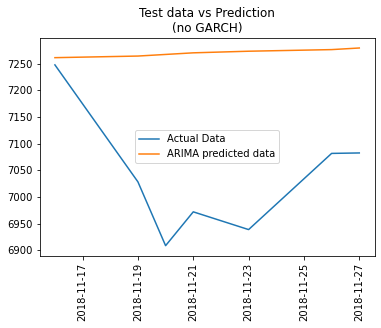

In [415]:
plt.plot(test_data, label='Actual Data')
plt.plot(ARIMA_predictions, label='ARIMA predicted data')
plt.title("Test data vs Prediction\n(no GARCH)")
plt.legend()
plt.xticks(rotation=90)
;

''

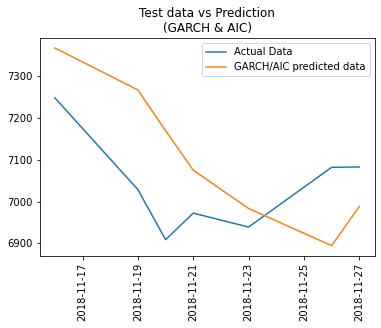

In [413]:
plt.plot(test_data, label='Actual Data')
plt.plot(garch_predicts_aic, label='GARCH/AIC predicted data')
plt.title("Test data vs Prediction\n(GARCH & AIC)")
plt.legend()
plt.xticks(rotation=90)
;

''

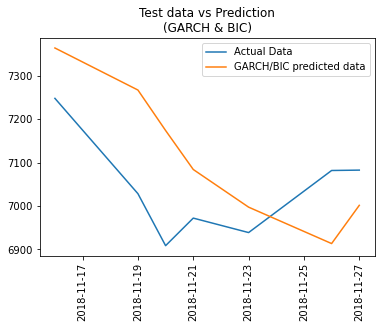

In [414]:
plt.plot(test_data, label='Actual Data')
plt.plot(garch_predicts_bic, label='GARCH/BIC predicted data')
plt.title("Test data vs Prediction\n(GARCH & BIC)")
plt.legend()
plt.xticks(rotation=90)
;

### MSE comparisons

In [417]:
### mse calcs
def mse(a,b=test_data):
    return np.mean((a.values-b.values)**2)
print(f"MSE calculations:\
\n-ARIMA only: {mse(ARIMA_predictions)}\
\n-GARCH with n,m chosen using AIC: {mse(garch_predicts_aic)}\
\n-GARCH with n,m chosen using BIC: {mse(garch_predicts_bic)}")


MSE calculations:
-ARIMA only: 65676.40556658163
-GARCH with n,m chosen using AIC: 40735.82670427845
-GARCH with n,m chosen using BIC: 39608.5674220461


In [422]:
best_procedure_1_mse = mse(garch_predicts_bic)

## Procedure1 Conclusions
As seen above, GARCH+ARIMA models perform better than the usual ARIMA only models

# Procedure 2

## Fitting ARMA on the residuals

In [426]:
residuals = chosen_model.resid
residuals

Date
2014-12-01   -0.013922
2014-12-02    0.005510
2014-12-03    0.003531
2014-12-04   -0.001451
2014-12-05    0.001947
                ...   
2018-11-09   -0.017047
2018-11-12   -0.028719
2018-11-13   -0.000572
2018-11-14   -0.009413
2018-11-15    0.016572
Length: 999, dtype: float64

In [478]:
residuals**2

Date
2014-12-01    1.938110e-04
2014-12-02    3.036479e-05
2014-12-03    1.246576e-05
2014-12-04    2.104859e-06
2014-12-05    3.789946e-06
                  ...     
2018-11-09    2.905931e-04
2018-11-12    8.247702e-04
2018-11-13    3.272849e-07
2018-11-14    8.860202e-05
2018-11-15    2.746293e-04
Length: 999, dtype: float64

In [441]:
## We already have our ARIMA_only_predictions (prediction of ARIMA without any forecast on error)
## from previous procedure, which predicts the returns of the stock
ARIMA_only_predictions

999     0.000325
1000    0.000416
1001    0.000416
1002    0.000416
1003    0.000416
1004    0.000416
1005    0.000416
Name: predicted_mean, dtype: float64

In [473]:
%%time

p_lim = 10
q_lim = 10
p_range = [i for i in range(p_lim+1)]
q_range = [i for i in range(q_lim+1)]
aic_matrix = [[None for _ in range(p_lim+1)] for __ in range(q_lim+1)]
bic_matrix = [[None for _ in range(p_lim+1)] for __ in range(q_lim+1)]
print("1. Setup: Basic Variables Set")

for p in p_range:
    for q in q_range:
        if p == 0 and q == 0:
            # arma(0,0) set to a high number (basically no prediction)
            aic_matrix[q][p] = 9999
            bic_matrix[q][p] = 9999
        else:
            model = ARIMA(residuals**2, order=(p,0,q))
            
            # fitting model to data
            results = model.fit()
            
            # recording the calculated aic and bic scores
            aic_matrix[q][p] = round(results.aic,3) # Imp: we set it as (q,p) not the usual (p,q)
            bic_matrix[q][p] = round(results.bic,3) # Imp: we set it as (q,p) not the usual (p,q)
print("\n2. Processing: Scores Calculation Done")  

# converting to numpy array for better computations
aic_matrix = np.array(aic_matrix)
bic_matrix = np.array(bic_matrix)

# Printing the best results
print("\n\n3. Outputs:")
print(f"Best index as per aic:{np.argwhere(aic_matrix == np.min(aic_matrix))}, score: {np.min(aic_matrix)}")
print(f"\nBest index as per bic:{np.argwhere(bic_matrix == np.min(bic_matrix))}, score: {np.min(bic_matrix)}")
best_tuples = list(np.argwhere(aic_matrix == np.min(aic_matrix)))
temp = list(np.argwhere(bic_matrix == np.min(bic_matrix)))
best_tuples.extend(temp)


1. Setup: Basic Variables Set

2. Processing: Scores Calculation Done


3. Outputs:
Best index as per aic:[[ 0 10]], score: -14222.009

Best index as per bic:[[1 1]], score: -14182.385
Wall time: 2min 48s


In [474]:
## recalling that the above results are encoded in the form (q,p) for ARMA(p,q)
## we have
aic_arima = ARIMA(residuals, order=(10,0,0)).fit()
bic_arima = ARIMA(residuals, order=(1,0,1)).fit()


## Forecasting with ARIMA on residuals

### error forecasts

In [481]:
aic_errors = np.sqrt(aic_arima.predict(start=1000,end=1006).abs())*signs # recall signs from procedure1
aic_errors.index = test_data.index
aic_errors

Date
2018-11-16    0.049693
2018-11-19   -0.012899
2018-11-20   -0.028409
2018-11-21   -0.057559
2018-11-23   -0.034749
2018-11-26   -0.044664
2018-11-27    0.037324
Name: predicted_mean, dtype: float64

In [482]:
bic_errors = np.sqrt(bic_arima.predict(start=1000,end=1006).abs())*signs # recall signs from procedure1
bic_errors.index = test_data.index
bic_errors

Date
2018-11-16    0.003257
2018-11-19   -0.000117
2018-11-20   -0.002011
2018-11-21   -0.001579
2018-11-23   -0.001757
2018-11-26   -0.001691
2018-11-27    0.001716
Name: predicted_mean, dtype: float64

### datapoints forecasts

In [483]:
# Adding the errors to the data
aic_ari2_predict = pd.Series(np.exp(np.log(ARIMA_predictions.values) + aic_errors.values),
                             index=test_data.index)

In [484]:
bic_ari2_predict = pd.Series(np.exp(np.log(ARIMA_predictions.values) + bic_errors.values),
                             index=test_data.index)

## Plots

''

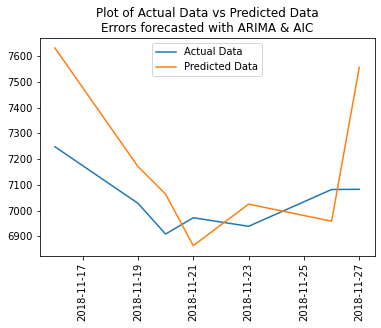

In [485]:
plt.plot(test_data, label='Actual Data')
plt.plot(aic_ari2_predict, label='Predicted Data')
plt.legend()
plt.title("Plot of Actual Data vs Predicted Data\nErrors forecasted with ARIMA & AIC")
plt.xticks(rotation=90)
;

''

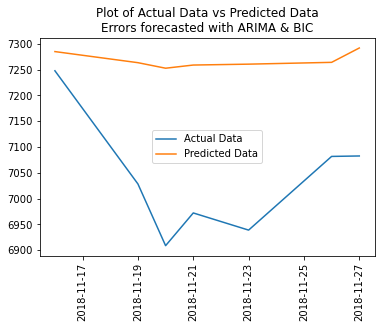

In [486]:
plt.plot(test_data, label='Actual Data')
plt.plot(bic_ari2_predict, label='Predicted Data')
plt.legend()
plt.title("Plot of Actual Data vs Predicted Data\nErrors forecasted with ARIMA & BIC")
plt.xticks(rotation=90)
;

## MSE
recall the function ```mse``` made in procedure1

In [487]:
print("MSE for AIC predictions")
print(mse(aic_ari2_predict))
print()
print("MSE for BIC predictions")
print(mse(bic_ari2_predict))

MSE for AIC predictions
108048.73277318788

MSE for BIC predictions
64774.08744423033


we have BIC forecast the one with lowest mse  
(Remark: despite the graphs seeming close for AIC one, please observe the scale on y-axis,
in reality, BIC one was a bit more closer to the test_data _on average_)

In [488]:
best_procedure_2_mse = mse(bic_ari2_predict)

# Final Results

In [489]:
print("Best mse we can do with GARCH (procedure1)")
print(best_procedure_1_mse)
print()
print("Best mse we can do with only ARIMA (procedure2)")
print(best_procedure_2_mse)

Best mse we can do with GARCH (procedure1)
39608.5674220461

Best mse we can do with only ARIMA (procedure2)
64774.08744423033


As seen above, we have a much better prediction using GARCH instead of ARIMA even though
both are similar in that they regress on themselves (i.e. the AR part), GARCH performs much
better because it assumes heteroscedasticity which is required for financial time series data
like the one we picked

In [ ]:
### end ###
